In [1]:
# load csv file and print the first 5 rows
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

df = pd.read_csv('datasets\MachineLearningCVE\combined data\combined_data_new_0306.csv')
df

,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMean,BwdPacketLengthStd,...,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_backward,act_data_pkt_fwd,ActiveStd,ActiveMax,IdleStd,Label
0,3167586,3,3,6,6,0,3.464102,6,2.000000,3.464102,...,3,6,3,6,29,1,0.0,0,0.0,0
1,8257899,21,30,993,38147,0,105.314834,4380,1271.566667,1082.743759,...,21,993,30,38147,141,19,0.0,0,0.0,0
2,212011,5,4,212,140,0,84.786791,128,35.000000,62.064483,...,5,212,4,140,237,4,0.0,0,0.0,1
3,67674,4,3,210,134,0,97.041228,128,44.666667,72.231111,...,4,210,3,134,237,3,0.0,0,0.0,1
4,996697,3,3,0,18,0,0.000000,6,6.000000,0.000000,...,3,0,3,18,0,0,0.0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88083,5025409,3,1,0,0,0,0.000000,0,0.000000,0.000000,...,3,0,1,0,28960,0,0.0,0,0.0,12
88084,4152634,3,1,0,0,0,0.000000,0,0.000000,0.000000,...,3,0,1,0,28960,0,0.0,0,0.0,12
88085,5157643,3,1,0,0,0,0.000000,0,0.000000,0.000000,...,3,0,1,0,28960,0,0.0,0,0.0,12
88086,2874333,2,0,0,0,0,0.000000,0,0.000000,0.000000,...,2,0,0,0,21027,0,0.0,0,0.0,12


In [2]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]


In [3]:
from sklearn.model_selection import train_test_split

# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [4]:
# # no use for now
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_val, y_val = np.array(X_val), np.array(y_val)
# X_test, y_test = np.array(X_test), np.array(y_test)

In [5]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [6]:
# # no use for now
# from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# class ClassifierDataset(Dataset):
    
#     def __init__(self, X_data, y_data):
#         self.X_data = X_data
#         self.y_data = y_data
        
#     def __getitem__(self, index):
#         return self.X_data[index], self.y_data[index]
        
#     def __len__ (self):
#         print(type(self.X_data))
#         return len(self.X_data)


# train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
# val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
# test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [7]:
## create dataloaders by myself
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
val_dataset = ClassifierDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())
test_dataset = ClassifierDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long())

In [8]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)
NUM_CLASSES = y.nunique()

In [9]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [10]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

###################### OUTPUT ######################
cuda:0

cpu


In [12]:
from torch import optim

model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


MulticlassClassification(
  (layer_1): Linear(in_features=42, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [13]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [14]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [15]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from datetime import datetime

print("Begin training.")
best_vloss = 1000000
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    train_epoch_acc_score = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        #print("train_data: ", X_train_batch, y_train_batch)
        # print train data shape  
        # X_train_batch:  torch.Size([64, 42]) y_train_batch torch.Size([64]) 
        # X_train_batch:  torch.Size([batch size, feature size]) y_train_batch torch.Size([batch size])
        #print("X_train_batch: ", X_train_batch.shape, "y_train_batch", y_train_batch.shape)
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        #print("X_train_batch: ", X_train_batch, "y_train_batch", y_train_batch)
        y_train_pred = model(X_train_batch)
        #print("y_train_pred: ", y_train_pred, y_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        # caculate train accuracy score from python package
        _, y_train_pred_tags = torch.max( y_train_pred, dim = 1)
        y_train_pred_tags.cpu().numpy()
        train_acc_score = accuracy_score(y_train_batch,  y_train_pred_tags)
        #print("train_acc_score: ", train_acc_score)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        train_epoch_acc_score += train_acc_score
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            #print("val_data: ", X_val_batch, y_val_batch)
            y_val_pred = model(X_val_batch)
            # print("y_val_pred: ", y_val_pred, y_val_batch)          
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    avg_vloss = val_epoch_loss/len(val_loader)       
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'target_DNN_model/targetDNN_model_{}_{}'.format(timestamp, EPOCHS)
        torch.save(model.state_dict(), model_path)                           
        
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    print(f'Epoch {e+0:03}: | Train Acc: {train_epoch_acc_score/len(train_loader):.3f}')

Begin training.


  2%|▏         | 1/50 [00:06<05:37,  6.88s/it]

Epoch 001: | Train Loss: 0.91729 | Val Loss: 0.69545 | Train Acc: 65.979| Val Acc: 69.164
Epoch 001: | Train Acc: 0.660


  4%|▍         | 2/50 [00:13<05:30,  6.89s/it]

Epoch 002: | Train Loss: 0.54626 | Val Loss: 0.41329 | Train Acc: 79.126| Val Acc: 83.695
Epoch 002: | Train Acc: 0.791


  6%|▌         | 3/50 [00:20<05:18,  6.78s/it]

Epoch 003: | Train Loss: 0.40100 | Val Loss: 0.38033 | Train Acc: 84.476| Val Acc: 84.547
Epoch 003: | Train Acc: 0.844


  8%|▊         | 4/50 [00:27<05:09,  6.74s/it]

Epoch 004: | Train Loss: 0.36238 | Val Loss: 0.36079 | Train Acc: 85.732| Val Acc: 86.008
Epoch 004: | Train Acc: 0.857


 10%|█         | 5/50 [00:33<05:02,  6.72s/it]

Epoch 005: | Train Loss: 0.34556 | Val Loss: 0.30677 | Train Acc: 86.424| Val Acc: 88.619
Epoch 005: | Train Acc: 0.864


 12%|█▏        | 6/50 [00:40<04:56,  6.75s/it]

Epoch 006: | Train Loss: 0.33641 | Val Loss: 0.43033 | Train Acc: 86.643| Val Acc: 82.475
Epoch 006: | Train Acc: 0.866


 14%|█▍        | 7/50 [00:47<04:48,  6.72s/it]

Epoch 007: | Train Loss: 0.32759 | Val Loss: 0.31519 | Train Acc: 86.824| Val Acc: 86.519
Epoch 007: | Train Acc: 0.868


 16%|█▌        | 8/50 [00:53<04:40,  6.68s/it]

Epoch 008: | Train Loss: 0.30882 | Val Loss: 0.28089 | Train Acc: 87.386| Val Acc: 88.861
Epoch 008: | Train Acc: 0.873


 18%|█▊        | 9/50 [01:00<04:33,  6.67s/it]

Epoch 009: | Train Loss: 0.30039 | Val Loss: 0.26006 | Train Acc: 87.709| Val Acc: 89.059
Epoch 009: | Train Acc: 0.876


 20%|██        | 10/50 [01:07<04:26,  6.66s/it]

Epoch 010: | Train Loss: 0.29553 | Val Loss: 0.26482 | Train Acc: 87.686| Val Acc: 89.967
Epoch 010: | Train Acc: 0.876


 22%|██▏       | 11/50 [01:13<04:18,  6.63s/it]

Epoch 011: | Train Loss: 0.28843 | Val Loss: 0.25129 | Train Acc: 88.006| Val Acc: 89.059
Epoch 011: | Train Acc: 0.879


 24%|██▍       | 12/50 [01:20<04:11,  6.61s/it]

Epoch 012: | Train Loss: 0.28242 | Val Loss: 0.27000 | Train Acc: 88.125| Val Acc: 89.428
Epoch 012: | Train Acc: 0.880


 26%|██▌       | 13/50 [01:26<04:04,  6.60s/it]

Epoch 013: | Train Loss: 0.28228 | Val Loss: 0.25419 | Train Acc: 88.020| Val Acc: 89.513
Epoch 013: | Train Acc: 0.879


 28%|██▊       | 14/50 [01:33<03:57,  6.60s/it]

Epoch 014: | Train Loss: 0.27367 | Val Loss: 0.26698 | Train Acc: 88.413| Val Acc: 89.471
Epoch 014: | Train Acc: 0.883


 30%|███       | 15/50 [01:40<03:50,  6.60s/it]

Epoch 015: | Train Loss: 0.26339 | Val Loss: 0.28503 | Train Acc: 88.617| Val Acc: 88.917
Epoch 015: | Train Acc: 0.885


 32%|███▏      | 16/50 [01:46<03:44,  6.59s/it]

Epoch 016: | Train Loss: 0.26231 | Val Loss: 0.28557 | Train Acc: 88.797| Val Acc: 88.548
Epoch 016: | Train Acc: 0.887


 34%|███▍      | 17/50 [01:53<03:37,  6.61s/it]

Epoch 017: | Train Loss: 0.25701 | Val Loss: 0.26620 | Train Acc: 88.985| Val Acc: 89.073
Epoch 017: | Train Acc: 0.889


 36%|███▌      | 18/50 [01:59<03:30,  6.59s/it]

Epoch 018: | Train Loss: 0.26386 | Val Loss: 0.26429 | Train Acc: 88.751| Val Acc: 89.357
Epoch 018: | Train Acc: 0.887


 38%|███▊      | 19/50 [02:06<03:23,  6.58s/it]

Epoch 019: | Train Loss: 0.25083 | Val Loss: 0.21231 | Train Acc: 89.074| Val Acc: 90.365
Epoch 019: | Train Acc: 0.890


 40%|████      | 20/50 [02:12<03:17,  6.59s/it]

Epoch 020: | Train Loss: 0.24863 | Val Loss: 0.21796 | Train Acc: 89.224| Val Acc: 90.280
Epoch 020: | Train Acc: 0.891


 42%|████▏     | 21/50 [02:19<03:11,  6.60s/it]

Epoch 021: | Train Loss: 0.24717 | Val Loss: 0.25058 | Train Acc: 89.171| Val Acc: 89.400
Epoch 021: | Train Acc: 0.891


 44%|████▍     | 22/50 [02:26<03:04,  6.59s/it]

Epoch 022: | Train Loss: 0.24043 | Val Loss: 0.27954 | Train Acc: 89.409| Val Acc: 88.861
Epoch 022: | Train Acc: 0.893


 46%|████▌     | 23/50 [02:32<02:58,  6.61s/it]

Epoch 023: | Train Loss: 0.23898 | Val Loss: 0.29551 | Train Acc: 89.424| Val Acc: 86.973
Epoch 023: | Train Acc: 0.893


 48%|████▊     | 24/50 [02:39<02:51,  6.61s/it]

Epoch 024: | Train Loss: 0.23222 | Val Loss: 0.23043 | Train Acc: 89.639| Val Acc: 90.010
Epoch 024: | Train Acc: 0.896


 50%|█████     | 25/50 [02:46<02:45,  6.62s/it]

Epoch 025: | Train Loss: 0.23495 | Val Loss: 0.21611 | Train Acc: 89.663| Val Acc: 91.812
Epoch 025: | Train Acc: 0.896


 52%|█████▏    | 26/50 [02:52<02:39,  6.63s/it]

Epoch 026: | Train Loss: 0.23361 | Val Loss: 0.21402 | Train Acc: 89.533| Val Acc: 91.259
Epoch 026: | Train Acc: 0.894


 54%|█████▍    | 27/50 [02:59<02:32,  6.63s/it]

Epoch 027: | Train Loss: 0.22836 | Val Loss: 0.20395 | Train Acc: 89.764| Val Acc: 90.606
Epoch 027: | Train Acc: 0.897


 56%|█████▌    | 28/50 [03:06<02:27,  6.68s/it]

Epoch 028: | Train Loss: 0.23201 | Val Loss: 0.23156 | Train Acc: 89.737| Val Acc: 90.478
Epoch 028: | Train Acc: 0.896


 58%|█████▊    | 29/50 [03:13<02:22,  6.78s/it]

Epoch 029: | Train Loss: 0.22773 | Val Loss: 0.23381 | Train Acc: 89.849| Val Acc: 90.280
Epoch 029: | Train Acc: 0.898


 60%|██████    | 30/50 [03:19<02:14,  6.74s/it]

Epoch 030: | Train Loss: 0.22571 | Val Loss: 0.22496 | Train Acc: 89.820| Val Acc: 91.401
Epoch 030: | Train Acc: 0.897


 62%|██████▏   | 31/50 [03:26<02:07,  6.70s/it]

Epoch 031: | Train Loss: 0.22210 | Val Loss: 0.24214 | Train Acc: 90.013| Val Acc: 90.719
Epoch 031: | Train Acc: 0.899


 64%|██████▍   | 32/50 [03:32<01:59,  6.66s/it]

Epoch 032: | Train Loss: 0.22407 | Val Loss: 0.20729 | Train Acc: 90.011| Val Acc: 90.932
Epoch 032: | Train Acc: 0.899


 66%|██████▌   | 33/50 [03:39<01:52,  6.64s/it]

Epoch 033: | Train Loss: 0.21907 | Val Loss: 0.19676 | Train Acc: 90.168| Val Acc: 91.046
Epoch 033: | Train Acc: 0.901


 68%|██████▊   | 34/50 [03:46<01:46,  6.66s/it]

Epoch 034: | Train Loss: 0.21800 | Val Loss: 0.21824 | Train Acc: 90.199| Val Acc: 91.372
Epoch 034: | Train Acc: 0.901


 70%|███████   | 35/50 [03:53<01:40,  6.69s/it]

Epoch 035: | Train Loss: 0.21253 | Val Loss: 0.21283 | Train Acc: 90.473| Val Acc: 90.322
Epoch 035: | Train Acc: 0.904


 72%|███████▏  | 36/50 [03:59<01:34,  6.75s/it]

Epoch 036: | Train Loss: 0.21438 | Val Loss: 0.21425 | Train Acc: 90.255| Val Acc: 90.138
Epoch 036: | Train Acc: 0.902


 74%|███████▍  | 37/50 [04:06<01:27,  6.74s/it]

Epoch 037: | Train Loss: 0.21432 | Val Loss: 0.19558 | Train Acc: 90.454| Val Acc: 90.989
Epoch 037: | Train Acc: 0.904


 76%|███████▌  | 38/50 [04:13<01:20,  6.71s/it]

Epoch 038: | Train Loss: 0.21095 | Val Loss: 0.23381 | Train Acc: 90.531| Val Acc: 89.400
Epoch 038: | Train Acc: 0.905


 78%|███████▊  | 39/50 [04:19<01:13,  6.67s/it]

Epoch 039: | Train Loss: 0.21269 | Val Loss: 0.24344 | Train Acc: 90.545| Val Acc: 90.209
Epoch 039: | Train Acc: 0.905


 80%|████████  | 40/50 [04:26<01:06,  6.65s/it]

Epoch 040: | Train Loss: 0.20999 | Val Loss: 0.24597 | Train Acc: 90.596| Val Acc: 90.166
Epoch 040: | Train Acc: 0.905


 82%|████████▏ | 41/50 [04:33<00:59,  6.64s/it]

Epoch 041: | Train Loss: 0.20773 | Val Loss: 0.24918 | Train Acc: 90.531| Val Acc: 90.748
Epoch 041: | Train Acc: 0.904


 84%|████████▍ | 42/50 [04:39<00:53,  6.65s/it]

Epoch 042: | Train Loss: 0.20626 | Val Loss: 0.23544 | Train Acc: 90.673| Val Acc: 90.223
Epoch 042: | Train Acc: 0.906


 86%|████████▌ | 43/50 [04:46<00:47,  6.72s/it]

Epoch 043: | Train Loss: 0.20619 | Val Loss: 0.20610 | Train Acc: 90.720| Val Acc: 91.188
Epoch 043: | Train Acc: 0.906


 88%|████████▊ | 44/50 [04:53<00:40,  6.76s/it]

Epoch 044: | Train Loss: 0.20536 | Val Loss: 0.23142 | Train Acc: 90.601| Val Acc: 91.557
Epoch 044: | Train Acc: 0.905


 90%|█████████ | 45/50 [05:00<00:33,  6.71s/it]

Epoch 045: | Train Loss: 0.20328 | Val Loss: 0.23232 | Train Acc: 90.737| Val Acc: 91.415
Epoch 045: | Train Acc: 0.907


 92%|█████████▏| 46/50 [05:06<00:26,  6.68s/it]

Epoch 046: | Train Loss: 0.20760 | Val Loss: 0.23675 | Train Acc: 90.560| Val Acc: 90.549
Epoch 046: | Train Acc: 0.905


 94%|█████████▍| 47/50 [05:13<00:19,  6.66s/it]

Epoch 047: | Train Loss: 0.20087 | Val Loss: 0.22703 | Train Acc: 90.806| Val Acc: 90.521
Epoch 047: | Train Acc: 0.907


 96%|█████████▌| 48/50 [05:19<00:13,  6.64s/it]

Epoch 048: | Train Loss: 0.20291 | Val Loss: 0.20101 | Train Acc: 90.810| Val Acc: 91.514
Epoch 048: | Train Acc: 0.907


 98%|█████████▊| 49/50 [05:26<00:06,  6.63s/it]

Epoch 049: | Train Loss: 0.19647 | Val Loss: 0.20670 | Train Acc: 90.890| Val Acc: 91.656
Epoch 049: | Train Acc: 0.908


100%|██████████| 50/50 [05:33<00:00,  6.66s/it]

Epoch 050: | Train Loss: 0.20229 | Val Loss: 0.20817 | Train Acc: 90.885| Val Acc: 92.564
Epoch 050: | Train Acc: 0.908


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

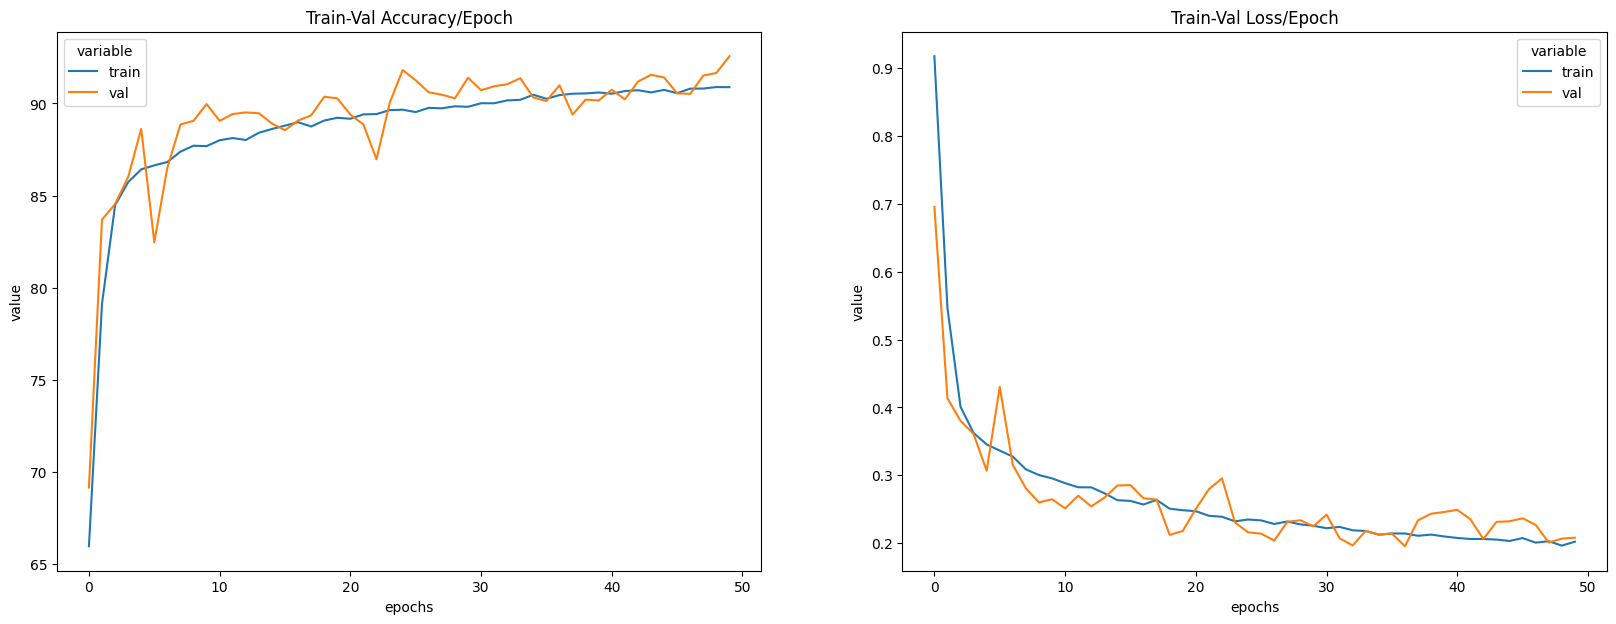

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns

# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [17]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        #print(_, y_pred_tags.cpu().numpy())
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [18]:
y_test.shape

(17618,)

In [19]:
len(y_pred_list)

17618

In [20]:
# test accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(accuracy_score(y_test, y_pred_list))

0.9225791803836985


In [28]:
y_test = y_test
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1355
           1       0.91      1.00      0.95      1355
           2       0.97      0.94      0.95      1355
           3       1.00      0.96      0.98      1355
           4       0.96      0.86      0.91      1355
           5       0.95      0.96      0.96      1355
           6       0.92      0.95      0.93      1356
           7       0.98      1.00      0.99      1355
           8       0.97      0.99      0.98      1355
           9       1.00      0.98      0.99      1356
          10       0.71      0.63      0.67      1355
          11       0.96      1.00      0.98      1356
          12       0.68      0.73      0.70      1355

    accuracy                           0.92     17618
   macro avg       0.92      0.92      0.92     17618
weighted avg       0.92      0.92      0.92     17618



<Axes: >

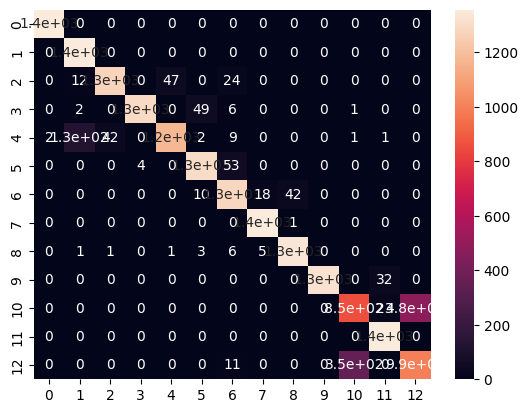

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True)

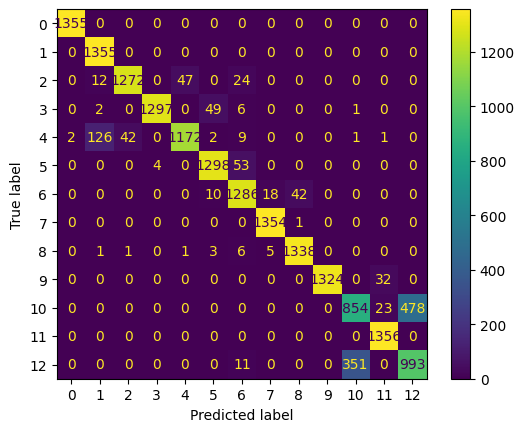

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_list),
                              display_labels=df['Label'].unique(),
                              )
disp.plot()

plt.show()